# This project analyzes the survival probability for Titanic passengers using their personal and onboard information. The datasets were downloaded from kaggle.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
%matplotlib inline

### Read the data file and check the main information

In [3]:
#This is the traing dataset hosted on Kaggle.
ti = pd.read_csv('./data/train.csv')
ti.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
ti.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
ti.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


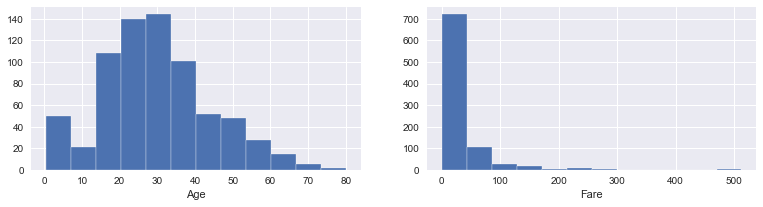

In [6]:
#check the distributions of age and fare by plotting.
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(13, 3))

ax1.hist(ti['Age'].dropna(), bins=12, edgecolor='white')
ax1.set_xlabel('Age')
ax2.set_xlabel('Fare')
ax2.hist(ti['Fare'], bins=12, edgecolor='white')
ax2.set_xlabel('Fare')

plt.show()
plt.close()

### Decide what to do with the missing values.

In [7]:
#take a look at NaN in Embarked.
ti[ti['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


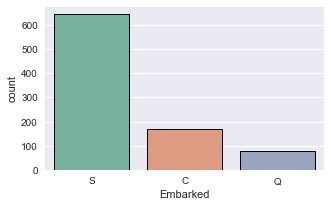

In [8]:
#plot the counts of the groups in Embarked 
fig,ax = plt.subplots(figsize=(5,3))
sns.countplot(data=ti,
              x='Embarked',
              orient='v',
              hue=None,
              order=None,
              hue_order=None,              
              color=None,
              palette='Set2',
              saturation=0.6,
              edgecolor='black',
              linewidth=1,
              ax=ax) 
sns.plt.show()

In [9]:
#Fill in the most common category S
ti['Embarked'].fillna('S', inplace=True)

#check to see the filled values.
ti[(ti['PassengerId'] == 62) | (ti['PassengerId'] == 830)].loc[:,'Embarked']

#Or, drop the two NaN values in gembark
#ti.dropna(axis=0, subset=['Embarked'], inplace=True)

61     S
829    S
Name: Embarked, dtype: object

In [10]:
#Check to see if the missing values in Age and Cabin occur randomly in the aspect of the survived outcome.
print('survival percentage for NaN Age passengers: ',ti[ti['Age'].isnull()].loc[:,'Survived'].mean())
print('survival percentage for NaN Cabin passengers: ',ti[ti['Cabin'].isnull()].loc[:,'Survived'].mean())
print('survival percentage for all passengers: ',ti['Survived'].mean())

survival percentage for NaN Age passengers:  0.2937853107344633
survival percentage for NaN Cabin passengers:  0.29985443959243085
survival percentage for all passengers:  0.3838383838383838


#### The survival of NaN passengers is only a little lower than that of the whole population. I will ignore Cabin. I will just impute Age Nan, with mean values of Sex and Pclass groups. I will further analyze the missing data after building the first model.

In [11]:
#impute Age Nan, with mean values of Sex and Pclass groups.
ti['Age_fill'] = ti.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))

#check if there is any NaN in the new column
print(ti['Age'].isnull().sum())
print(ti['Age_fill'].isnull().sum())

177
0


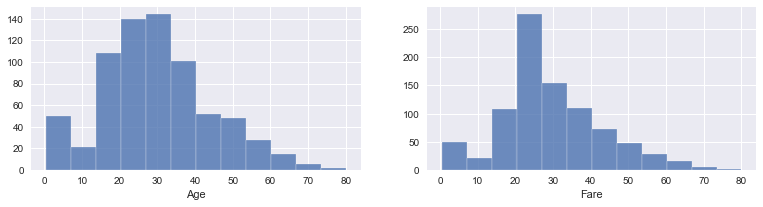

In [12]:
#check the distributions of Age, and Age_fill
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(13, 3))

ax1.hist(ti['Age'].dropna(), bins=12, edgecolor='white', alpha=0.8)
ax1.set_xlabel('Age')
ax2.set_xlabel('Age_fill')
ax2.hist(ti['Age_fill'], bins=12, edgecolor='white', alpha=0.8)
ax2.set_xlabel('Fare')

plt.show()
plt.close()

### Check the categorial features to see if the survival is random across the groups. If survival is not random, it would be a good idea to use the categorial features.

In [13]:
#percentage of survival by Pclass, Sex, SibSp, Parch, Embarked
print(ti.groupby(['Pclass'])['Survived'].mean())
print('\n',ti.groupby(['Sex'])['Survived'].mean())
print('\n',ti.groupby(['SibSp'])['Survived'].mean())
print('\n',ti.groupby(['Parch'])['Survived'].mean())
print('\n',ti.groupby(['Embarked'])['Survived'].mean())

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

 Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

 SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64

 Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64

 Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64


#### Survival was not random among the groups of the categorical features.

### Prepare features for training.

In [14]:
#code male as 0 female as 1
ti['gsex'] = ti['Sex'].apply(lambda x: 1 if (x == 'female') else 0)

#code Embarked 0 as C, 1 as Q and 2 as S
ti['gembark'] = ti['Embarked'].apply(lambda x: 0 if (x == 'C') else 1 if (x == 'Q') else 2)

#seperate SibSp into 3 groups of different survival rates
ti['gsibsp'] = ti['SibSp'].apply(lambda x: 0 if (x == 0) else 1 if (x in [3,4,5,8]) else 2)

#seperate Parch into 3 groups of different survival rates
ti['gparch'] = ti['Parch'].apply(lambda x: 0 if (x == 0) else 1 if (x in [4,5,6]) else 2)

In [15]:
#create a family column = SibSp + Parch
ti['family'] = ti['SibSp'] + ti['Parch']

#extract salute and create a new column and make sure I extracted something for every row.
ti['sal'] = ti['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
ti['sal'].isnull().sum() 

0

In [16]:
#check percentage of survival for the new columns
print(ti.groupby(['family'])['Survived'].mean())
print('\n',ti.groupby(['sal'])['Survived'].mean(), ti.groupby(['sal'])['Survived'].count())

family
0     0.303538
1     0.552795
2     0.578431
3     0.724138
4     0.200000
5     0.136364
6     0.333333
7     0.000000
10    0.000000
Name: Survived, dtype: float64

 sal
Capt        0.000000
Col         0.500000
Countess    1.000000
Don         0.000000
Dr          0.428571
Jonkheer    0.000000
Lady        1.000000
Major       0.500000
Master      0.575000
Miss        0.697802
Mlle        1.000000
Mme         1.000000
Mr          0.156673
Mrs         0.792000
Ms          1.000000
Rev         0.000000
Sir         1.000000
Name: Survived, dtype: float64 sal
Capt          1
Col           2
Countess      1
Don           1
Dr            7
Jonkheer      1
Lady          1
Major         2
Master       40
Miss        182
Mlle          2
Mme           1
Mr          517
Mrs         125
Ms            1
Rev           6
Sir           1
Name: Survived, dtype: int64


#### Survival in the family and sal groups was not random. I will use sal. I will not use family because it is likely redundant to SibSp and Parch. One option may be using family instead of SibSp and Parch.

In [17]:
#seperate sal into low, medium, and high survival groups, 0, 1, 2
high = ['Countess','Lady','Mlle','Mme','Ms','Sir','Miss','Mrs']
medium = ['Col','Dr','Major','Master']
ti['gsal'] = ti['sal'].apply(lambda x: 2 if x in high else 1 if x in medium else 0) 
ti['gsal'].iloc[10:20]

10    2
11    2
12    0
13    0
14    2
15    2
16    1
17    0
18    2
19    2
Name: gsal, dtype: int64

### Now make a new df to plot the categorial varibles to see if they are useful for classification.

In [18]:
ti_plot = ti[['Survived','gsex','Age_fill','Fare','gembark','gparch','gsibsp','Pclass', 'gsal']]

In [19]:
ti_plot.head(2)

,Survived,gsex,Age_fill,Fare,gembark,gparch,gsibsp,Pclass,gsal
0,0,0,22.0,7.2500,2,0,2,3,0
1,1,1,38.0,71.2833,0,0,2,1,2


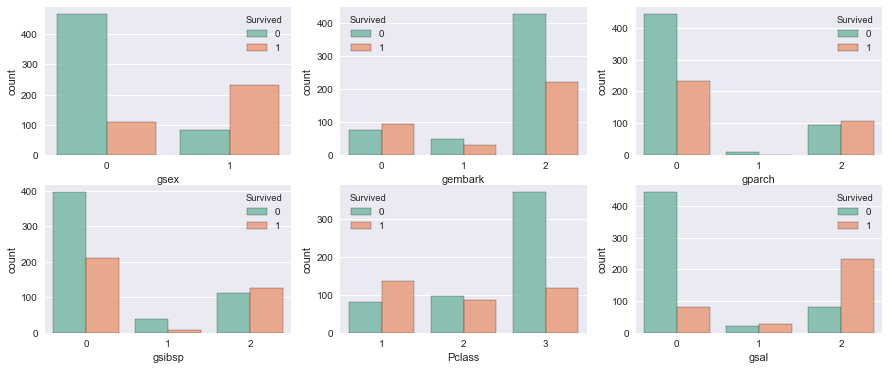

In [37]:
#count plots for the categorial variables.
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(15, 6))
for var, ax in zip(['gsex','gembark','gparch','gsibsp','Pclass', 'gsal'],axes.flat):
    sns.countplot(x=var, hue="Survived", data=ti_plot, edgecolor='black', palette="Set2", alpha=0.8, ax=ax)
sns.plt.show()

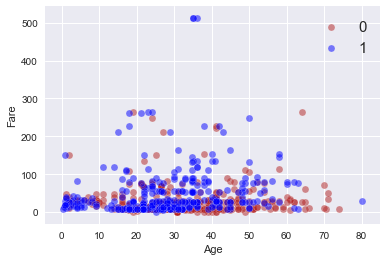

In [21]:
#plot Fare and Age, colored by survival.
colors = {0:'firebrick', 1:'blue'}
groups = ti_plot.groupby(by=['Survived'])
for name, g in groups:
    plt.scatter(x=g['Age_fill'], y=g['Fare'], label=name, edgecolor='white', color=colors[name], alpha=0.5)
plt.legend(loc='best', prop={'size':15}, frameon=False)
plt.xlabel('Age')
plt.ylabel('Fare')

### Summary of data:
#### Female (1) had a higher survival rate than male (2).
#### People emarked from the S port (2) had a relatively low survial rate.
#### People having no or too many parents/children (0 or 1) had lower chances to survive.
#### People having no or too many siblings/spouses (0 or 1) had lower chances to survive. 
#### People in class 1 had slighly higher chances to survive, while those in class 3 had very low chances.
#### People with name titles in group 0 had very low chances to survive, while those in group 2 had much higher chances.
####  Fare and Age only mildly separate the survived from the lost. Old passengers with low ticket fares seem to have had lower survival rates.

### Now do the final preparation for the varialbes and combine them for modeling.

In [22]:
#dummy coding
pclass = pd.get_dummies(ti['Pclass'],prefix='pclass').drop('pclass_1', axis=1)
sibsp = pd.get_dummies(ti['gsibsp'],prefix='gsibsp').drop('gsibsp_0', axis=1)
parch = pd.get_dummies(ti['gparch'],prefix='gparch').drop('gparch_0', axis=1)
embark = pd.get_dummies(ti['gembark'],prefix='gembark').drop('gembark_0', axis=1)
sal = pd.get_dummies(ti['gsal'],prefix='gsal').drop('gsal_0', axis=1)

In [23]:
#create df_ti for training
df_ti = ti[['Survived','gsex','Age_fill','Fare']].join(pclass).join(sibsp).join(parch).join(embark).join(sal)

#create X_lr for logistic regression
X_lr = df_ti.drop(['Survived'], axis=1)

#create y_all for all type of classification training and logistic regression.
y_all = df_ti['Survived']

### Model training and evaluation.

In [24]:
#If there is no testing data, split the whole dataset into a training set and test set
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

In [25]:
#grid search with logistic regression
params1 = {'solver':['liblinear'],
           'penalty':['l1','l2'],
           'C':[0.1,1,10]}
kf1 = KFold(n_splits=10, shuffle=True)
gs1 = GridSearchCV(estimator=LogisticRegression(),param_grid=params1,cv=kf1,scoring='accuracy')
lr_mod1 = gs1.fit(X_lr, y_all)
print('Done!')

Done!


In [29]:
#output the statistics of the logistic regression model
print(pd.DataFrame(lr_mod1.cv_results_))
print('\n',lr_mod1.best_estimator_)
print('\n','Best Score: ',lr_mod1.best_score_)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       0.006173         0.000486         0.796857          0.803841     0.1   
1       0.005683         0.000492         0.814815          0.820925     0.1   
2       0.007864         0.000352         0.823793          0.827410       1   
3       0.003900         0.000301         0.820426          0.826662       1   
4       0.008399         0.000321         0.822671          0.829156      10   
5       0.004175         0.000298         0.823793          0.829280      10   

  param_penalty param_solver  \
0            l1    liblinear   
1            l2    liblinear   
2            l1    liblinear   
3            l2    liblinear   
4            l1    liblinear   
5            l2    liblinear   

                                              params  rank_test_score  \
0  {'C': 0.1, 'penalty': 'l1', 'solver': 'libline...                6   
1  {'C': 0.1, 'penalty': 'l2', 'solver': 'libline...                

### The accuracy score is good enough. The K-fold cross validation suggests that there is no apparent overfitting. 

---

### Further analyze the feasibility of using the rest of the features, Cabin and Ticket.
### First, check the Cabin feature which is damaged by a lot of missing values.

In [26]:
#group Pclass and count the total passengers
total = ti.groupby(['Pclass'])['Survived'].count()
total

Pclass
1    216
2    184
3    491
Name: Survived, dtype: int64

In [27]:
#group Pclass for the missing Cabin passengers and count the numbers
ca_null = ti[ti['Cabin'].isnull()].groupby(['Pclass'])['Survived'].count()
ca_null

Pclass
1     40
2    168
3    479
Name: Survived, dtype: int64

In [28]:
#percentages of missing Cabin values grouped by Pclass
ca_null/total

Pclass
1    0.185185
2    0.913043
3    0.975560
Name: Survived, dtype: float64

In [29]:
#percentages of existing Cabin values grouped by Pclass
ca_exist = ti[ti['Cabin'].notnull()].groupby(['Pclass'])['Survived'].count()
ca_exist/total

Pclass
1    0.814815
2    0.086957
3    0.024440
Name: Survived, dtype: float64

### Cabin informaiton loss was not random. Make plots to have a better view.

In [30]:
#create a cabin column with null values coded 0 and notnull values coded 1.
ti['cabin']=ti['Cabin'].notnull().astype('int')

#check the new column.
print(ti['cabin'].isnull().sum())
ti[['cabin','Cabin']].head()

0


,cabin,Cabin
0,0,NaN
1,1,C85
2,0,NaN
3,1,C123
4,0,NaN


In [31]:
#Add the new cabin column to the plotting dataframe.
ti_plot = ti_plot.join(ti['cabin'])

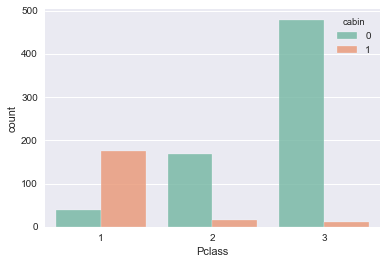

In [36]:
#Plot the number of cabin information status, known (1) and missing (0), across different Pclasses.
ax = sns.countplot(x='Pclass', hue="cabin", data=ti_plot, edgecolor='white', palette="Set2", alpha=0.8)
sns.plt.show()

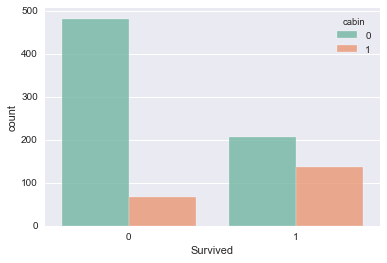

In [33]:
ax = sns.countplot(x='Survived', hue="cabin", data=ti_plot, edgecolor='white', palette="Set2", alpha=0.8)
sns.plt.show()

### Summary of data missing for the cabin category:
#### Most passengers in Pclass 2 and 3 lost cabin information!! In contrast, only 40 out of 216 survived class 1 passengers lost cabin information.
#### People didn't survive titanic had a much higher rate of losing cabine information.

### Now, build a model with the new cabin column.

In [33]:
#Add the new cabin column to the training dataset
df_ti2 = df_ti.join(ti['cabin'])

#Extract all the predictors for logistic regression
X_lr2 = df_ti2.drop(['Survived'], axis=1)

In [35]:
params2 = {'solver':['liblinear'],
           'penalty':['l1','l2'],
           'C':[0.1,1,10]}
kf2 = KFold(n_splits=20, shuffle=True)
gs2 = GridSearchCV(estimator=LogisticRegression(),param_grid=params2,cv=kf2,scoring='accuracy')
lr_mod2 = gs2.fit(X_lr2, y_all)
print('Done!')

Done!


In [37]:
#Output the results
print(pd.DataFrame(lr_mod2.cv_results_))
print('\n',lr_mod2.best_estimator_)
print('\n','Best Score: ',lr_mod2.best_score_)

   mean_fit_time  mean_score_time  mean_test_score  mean_train_score param_C  \
0       0.006594         0.000482         0.801347          0.809912     0.1   
1       0.003652         0.000297         0.821549          0.827397     0.1   
2       0.009777         0.000302         0.828283          0.833954       1   
3       0.004102         0.000293         0.822671          0.831828       1   
4       0.010515         0.000299         0.826038          0.833186      10   
5       0.004455         0.000296         0.824916          0.833127      10   

  param_penalty param_solver  \
0            l1    liblinear   
1            l2    liblinear   
2            l1    liblinear   
3            l2    liblinear   
4            l1    liblinear   
5            l2    liblinear   

                                              params  rank_test_score  \
0  {'C': 0.1, 'penalty': 'l1', 'solver': 'libline...                6   
1  {'C': 0.1, 'penalty': 'l2', 'solver': 'libline...                

### There is however no apparent improvement.

### Take another look at the missing values for the Age feature.

In [36]:
#group and count the missing Age passengers
total_age = ti.groupby(['Sex'])['Survived'].count()
age_null = ti[ti['Age'].isnull()].groupby(['Sex'])['Survived'].count()
print(age_null, age_null/total_age)

Sex
female     53
male      124
Name: Survived, dtype: int64 Sex
female    0.168790
male      0.214905
Name: Survived, dtype: float64


### Age missing is not significantly baised among groups of Pclass, family, Sex, et al. It is random.

### Second, the Ticket numbers.

In [687]:
ti[['Ticket', 'Pclass']].head(10)

,Ticket,Pclass
0,A/5 21171,3
1,PC 17599,1
2,STON/O2. 3101282,3
3,113803,1
4,373450,3
5,330877,3
6,17463,1
7,349909,3
8,347742,3
9,237736,2


### Ticket number may be related to pclass and may be categorized

In [752]:
#extract digits from Ticket and save it in a new column tick.
ti['tick'] = ti['Ticket'].str.extract('(\d+\Z)', expand=False)
#ti[['tick', 'Pclass']]
ti[ti['tick'].isnull()].ix[:,'Ticket']

179    LINE
271    LINE
302    LINE
597    LINE
Name: Ticket, dtype: object

### I don't know what to do with this yet.

### Now build a decision tree model

In [38]:
#create data for decision tree training.
tree_df = ti[['Survived','Pclass','gsal','gsex','gsibsp','gparch','Fare','cabin','gembark']]
tree_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
gsal        891 non-null int64
gsex        891 non-null int64
gsibsp      891 non-null int64
gparch      891 non-null int64
Fare        891 non-null float64
cabin       891 non-null int64
gembark     891 non-null int64
dtypes: float64(1), int64(8)
memory usage: 62.7 KB


In [39]:
#create X and y for decision tree training.
X = tree_df.drop('Survived',axis=1)
y = tree_df['Survived']

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

params3 = {'criterion':['gini','entropy'],
           'splitter':['best','random'],
           'min_samples_split':[2,5,8,11],
           'min_samples_leaf':[10,15,20,25,30]}
kf3 = KFold(n_splits=10, shuffle=True)
gs3 = GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=params3,cv=kf3,scoring='accuracy')
tree_mod = gs3.fit(X, y)
print('Done!')

Done!


In [41]:
#output the results
#print(pd.DataFrame(tree_mod.cv_results_))
print('\n',tree_mod.best_estimator_)
print('\n','Best Score: ',tree_mod.best_score_)


 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=30,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

 Best Score:  0.833894500561


## Cross validation using the testing dataset on kaggle.

In [42]:
#Prepare the test dataset from kaggle for evaluation of the model.
df_test=pd.read_csv('./data/test.csv')
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [43]:
#prepare the features. 
df_test['gsex'] = df_test['Sex'].apply(lambda x: 1 if (x == 'female') else 0)
df_test['gembark'] = df_test['Embarked'].apply(lambda x: 0 if (x == 'C') else 1 if (x == 'Q') else 2)
df_test['gsibsp'] = df_test['SibSp'].apply(lambda x: 0 if (x == 0) else 1 if (x in [3,4,5,8]) else 2)
df_test['gparch'] = df_test['Parch'].apply(lambda x: 0 if (x == 0) else 1 if (x in [4,5,6]) else 2)
df_test['sal'] = df_test['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
df_test['gsal'] = df_test['sal'].apply(lambda x: 2 if x in high else 1 if x in medium else 0) 
df_test['cabin'] = df_test['Cabin'].notnull().astype('int')
df_test['Age_fill'] = df_test.groupby(['Sex', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))

In [44]:
#check where is the Fare NaN
df_test[df_test['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,gsex,gembark,gsibsp,gparch,sal,gsal,cabin,Age_fill
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,0,2,0,0,Mr,0,0,60.5


In [45]:
#calculate the mean of class 3 passenger fares
df_test.groupby(['Pclass']).get_group((3))['Fare'].mean()

12.459677880184334

In [46]:
#fill in the mean of class 3 passenger fares
df_test['Fare']=df_test['Fare'].fillna(12.5)
df_test.ix[152,'Fare']

12.5

In [47]:
#create X test set for evalution of decision tree models
X_tree_test = df_test[['Pclass','gsal','gsex','gsibsp','gparch','Fare','cabin','gembark']]

In [48]:
#creat y test set for evaluation of all types of models.
sub = pd.read_csv('./data/gender_submission.csv')
y_all_test = sub['Survived']

In [49]:
#create X test set for evalution of logistic regression
pclass_t = pd.get_dummies(df_test['Pclass'],prefix='pclass').drop('pclass_1', axis=1)
sibsp_t = pd.get_dummies(df_test['gsibsp'],prefix='gsibsp').drop('gsibsp_0', axis=1)
parch_t = pd.get_dummies(df_test['gparch'],prefix='gparch').drop('gparch_0', axis=1)
embark_t = pd.get_dummies(df_test['gembark'],prefix='gembark').drop('gembark_0', axis=1)
sal_t = pd.get_dummies(df_test['gsal'],prefix='gsal').drop('gsal_0', axis=1)
X_lr_test1 = df_test[['gsex','Age_fill','Fare']].join(pclass_t).join(sibsp_t).join(parch_t).join(embark_t).join(sal_t)
X_lr_test2 = X_lr_test1.join(df_test['cabin'])

In [50]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score

#creating a plot_roc_curve funstion that we can call later
def plot_roc_curve(target_test, target_predicted_proba, label):
    fpr, tpr, thresholds = roc_curve(target_test, target_predicted_proba[:,1], drop_intermediate=False)
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    fig, ax = plt.subplots(figsize=(3.5,3.5))
    ax.plot(fpr, tpr, 'r-', label= label + '\n' + 'ROC Area = %0.3f' % roc_auc)
    ax.plot([0, 1], [0, 1], 'k-.')
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_xlabel('False Positive Rate (1 - Specifity)', fontsize=12)
    ax.set_ylabel('True Positive Rate (Sensitivity)',fontsize=12)
    plt.legend(loc='lower right',fontsize=12)
    plt.title('Receiver Operating Characteristic',fontsize=12)

Model_1 Accuracy:  0.942583732057 

Model_2 Accuracy:  0.930622009569 

Model_3 Accuracy:  0.8995215311 



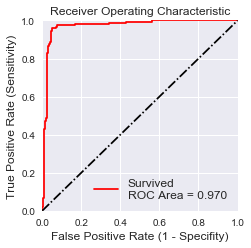

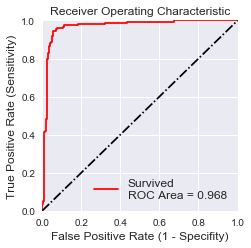

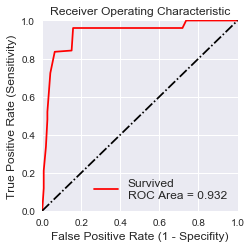

In [51]:
#calling roc curve function
plot_roc_curve(y_all_test, lr_mod1.predict_proba(X_lr_test1), 'Survived')
print('Model_1 Accuracy: ',accuracy_score(y_all_test,lr_mod1.predict(X_lr_test1)),'\n')
plot_roc_curve(y_all_test, lr_mod2.predict_proba(X_lr_test2), 'Survived')
print('Model_2 Accuracy: ',accuracy_score(y_all_test,lr_mod2.predict(X_lr_test2)),'\n')
plot_roc_curve(y_all_test, tree_mod.predict_proba(X_tree_test), 'Survived')
print('Model_3 Accuracy: ',accuracy_score(y_all_test,tree_mod.predict(X_tree_test)),'\n')

### The logistic Regression models worked well on the test data set with higher accuracy scores and AUC values. Adding the cabin feature didn't help. The decision tree model was slightly weaker.